# Oceanum 400m Tidal Data

In [1]:
from oceanum.datamesh import Connector
import os
import dotenv

dotenv.load_dotenv("/home/sebastien/.env/.datamesh")

token = os.getenv("OCEANUM_USER_IO_TOKEN")

datamesh = Connector(service="https://datamesh.oceanum.tech",
                     token=token)

First thing let's load the dataset structure.

The dataset has 3 types of variables:
- 2 static spatial variables, landmask and dep, which repectively decribes the location of the land and ocean and the depth.
- constituents variables (h, u, v). Those are complex numbers that describing the different tidal quantities as harmonics.
- time series variables (h_ts, u_ts, v_ts). Those are the time series of the different tidal quantities.

The 3 main variables available in constituent and time series form are:
- h: the tidal elevation
- u: the tidal current velocity in the x direction
- v: the tidal current velocity in the y direction

The grid the data is available on is of 400 m resolution over the whole planet. It is backed by two sets of grids, a high resolution set of 400 m resolution that covers coastlines and a lower resolution one that covers the whole planet at a resolution of 4 km. The present dataset always return 400 m resolution which depending on the location will be either high resolution data or interpolated lower resolution data.

Time time resolution of the data is somewhat arbitrary because the timeseries are generated on the fly from the harmonic coefficients. It is set by default to 1 hour but can be adjusted when querying the data.

This dataset is a very large with the full size of each constituent and timeseries variable being about 420 Gb and 7 Pb respectively. For that reason direct interaction with the full lazy xarray object will fail and users have to use the query interface to filter the data.


In [2]:
new = datamesh.load_datasource("oceanum_global_multiscale_tidegrid")
new

/home/sebastien/.env/datamesh/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


<xarray.Dataset> Size: 24PB
Dimensions:   (con: 14, lat: 45001, lon: 90000, time: 485637)
Coordinates:
  * con       (con) <U4 224B 'M2' 'S2' 'N2' 'K2' 'K1' ... 'M4' 'MN4' 'MS4' '2N2'
  * lat       (lat) float64 360kB -90.0 -90.0 -89.99 -89.99 ... 89.99 90.0 90.0
  * lon       (lon) float64 720kB 0.0 0.004 0.008 0.012 ... 360.0 360.0 360.0
  * time      (time) datetime64[ns] 4MB 1970-01-01 ... 2025-05-26T20:00:00
Data variables:
    dep       (lat, lon) float32 16GB dask.array<chunksize=(128, 128), meta=np.ndarray>
    h         (con, lat, lon) complex64 454GB dask.array<chunksize=(14, 128, 128), meta=np.ndarray>
    h_ts      (time, lat, lon) float32 8PB dask.array<chunksize=(1024, 128, 128), meta=np.ndarray>
    landmask  (lat, lon) float16 8GB dask.array<chunksize=(128, 128), meta=np.ndarray>
    u         (con, lat, lon) complex64 454GB dask.array<chunksize=(14, 128, 128), meta=np.ndarray>
    u_ts      (time, lat, lon) float32 8PB dask.array<chunksize=(1024, 128, 128), meta=np.ndarray>
    v         (con, lat, lon) complex64 454GB dask.array<chunksize=(14, 128, 128), meta=np.ndarray>
    v_ts      (time, lat, lon) float32 8PB dask.array<chunksize=(1024, 128, 128), meta=np.ndarray>

# Example query 1

Request for a time series of tidal elevation at a specific location followed by plot of data.

In [2]:
query = datamesh.query({"datasource": "oceanum_global_multiscale_tidegrid",
                        "timefilter": {"type": "range",
                                       "times": ["2000-01-01T00:00:00", "2001-01-03T00:00:00"],},
                        "geofilter": {"type": "feature",
                                      "geom": {
                                          "type": "Feature",
                                          "geometry": {
                                              "type": "Point",
                                              "coordinates": [174.81259, -37.80185]
                                          }
                                      }
                        },
                        "variables": ["h_ts"]
                })
query # 6:20s for 20 years of data

/home/sebastien/.env/datamesh/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


<xarray.Dataset> Size: 3MB
Dimensions:      (time: 175369)
Coordinates:
  * time         (time) datetime64[ns] 1MB 2000-01-01 ... 2020-01-03
    spatial_ref  int64 8B 0
Data variables:
    h_ts         (time) float64 1MB -0.7538 -0.5449 ... -0.3913 -0.009412
Attributes:
    description:     Oceantide tidal constituents
    version:         v0.2
    xinterp_method:  linear
    _coordinates:    {"t":"time","x":"lon","y":"lat"}
    _request_size:   2805912

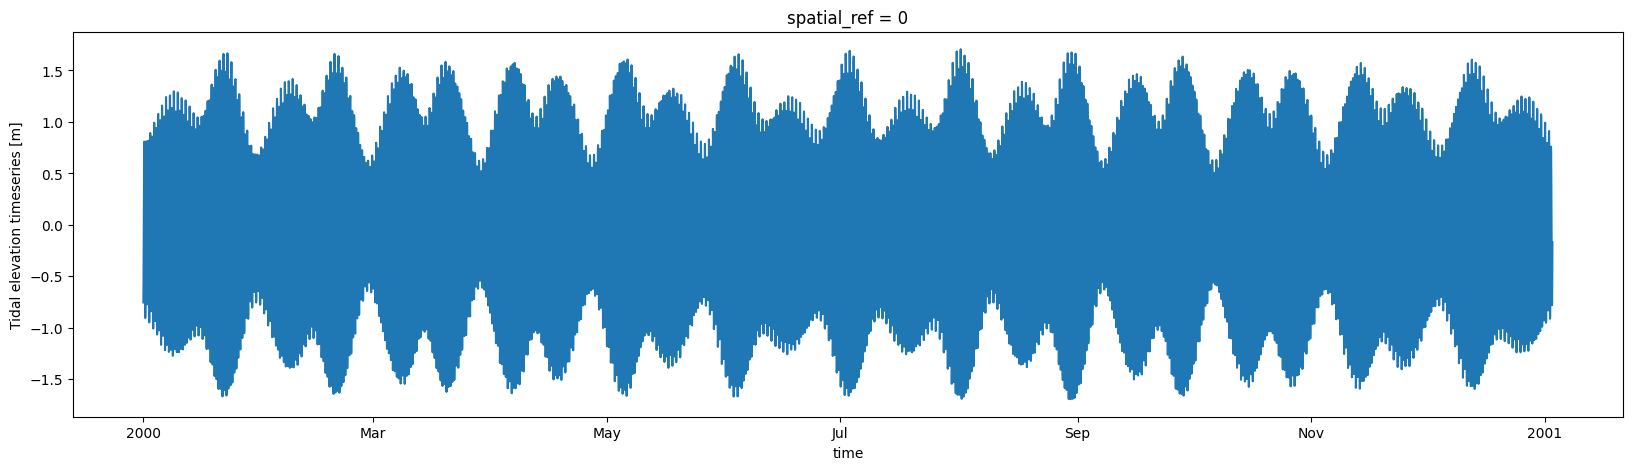

In [16]:
query.h_ts.plot(figsize=(20,5))

# Example query 2

Request for a time series of tidal currents at 30 minute resolution at a specific location for the coming week followed by plot of data.

In [19]:
query = datamesh.query({"datasource": "oceanum_global_multiscale_tidegrid",
                        "timefilter": {"type": "range",
                                       "times": ["2024-05-27T00:00:00", "2024-06-04T00:00:00"],
                                       "resolution": "30min"},
                        "geofilter": {"type": "feature",
                                      "geom": {
                                          "type": "Feature",
                                          "geometry": {
                                              "type": "Point",
                                              "coordinates": [174.81259, -37.80185]
                                          }
                                      }
                        },
                        "variables": ["u_ts", "v_ts"]
                })
query

<xarray.Dataset> Size: 9kB
Dimensions:      (time: 385)
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 3kB 2024-05-27 ... 2024-06-04
Data variables:
    u_ts         (time) float64 3kB -0.0002601 -0.00519 ... -0.02261 -0.01985
    v_ts         (time) float64 3kB 0.0007569 0.00344 ... 0.01244 0.01076
Attributes:
    description:     Oceantide tidal constituents
    version:         v0.2
    xinterp_method:  linear
    _coordinates:    {"t":"time","x":"lon","y":"lat"}
    _request_size:   9248

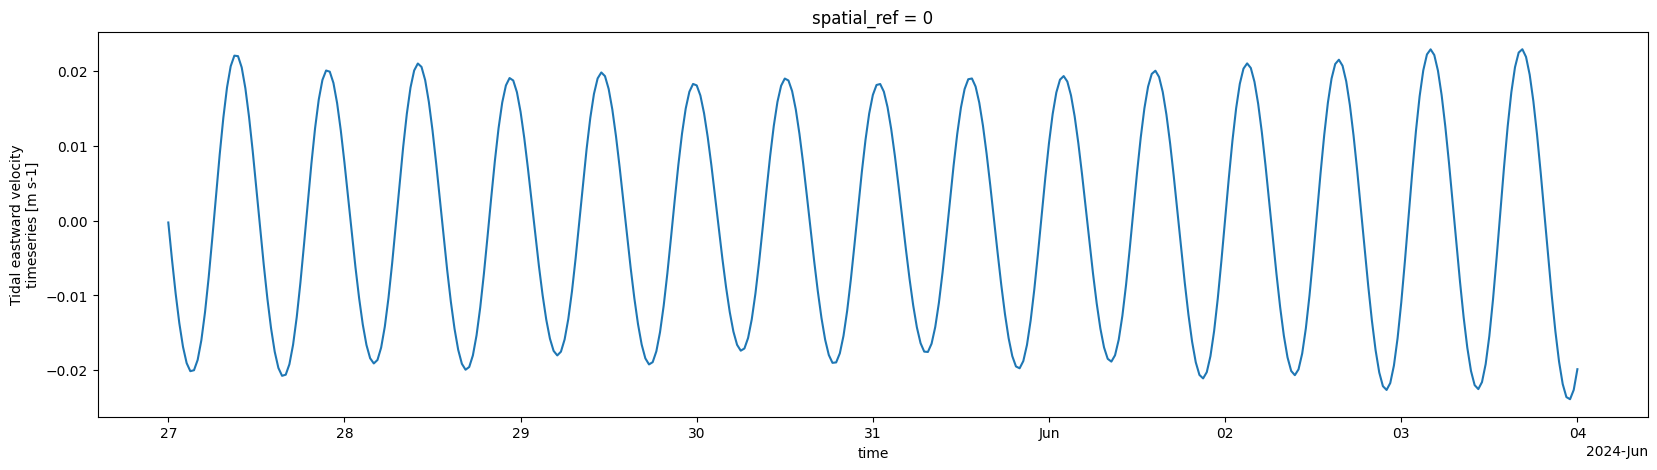

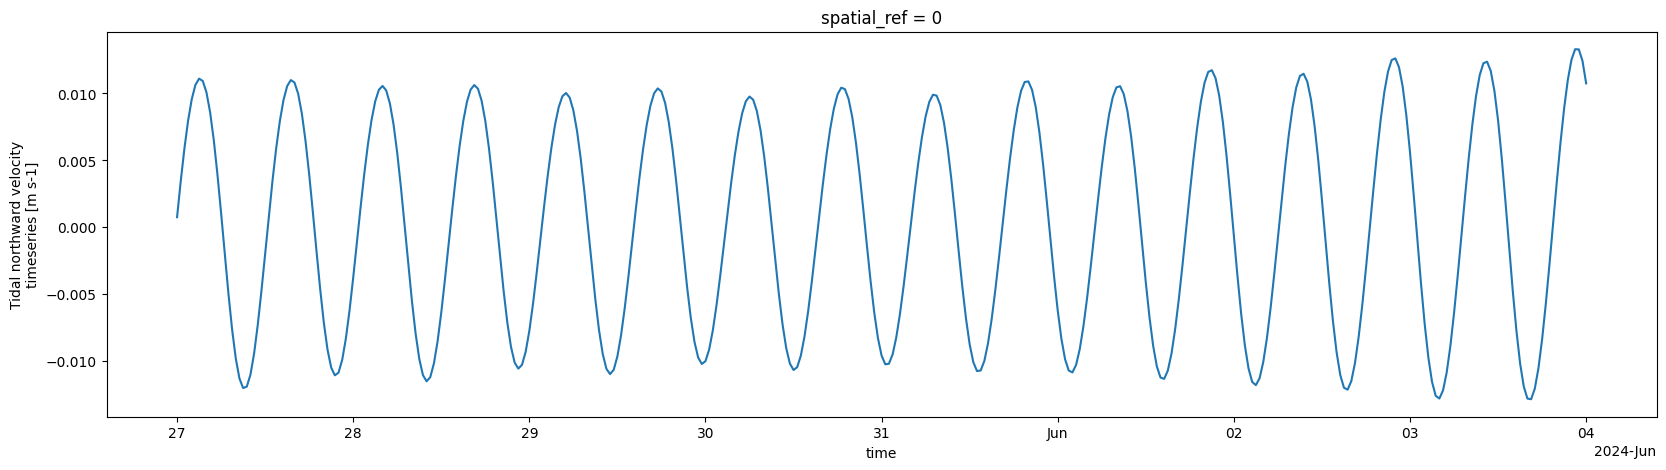

In [21]:
query.u_ts.plot(figsize=(20,5))
query.v_ts.plot(figsize=(20,5))

# Example query 3

Tidal elevation and constituents for a grid in the English Channel.
Data is requested for 7 days at a resolution of 30 minutes.

In [3]:
query = datamesh.query({"datasource": "oceanum_global_multiscale_tidegrid",
                        "timefilter": {"type": "range",
                                       "times": ["2000-01-01T00:00:00", "2000-01-07T00:00:00"],
                                                                              "resolution": "30min"},
                        "geofilter": {"type": "bbox",
                                      "geom": [0.5, 50.6 ,2.5, 51.4]
                        },
                        "variables": ["h", "h_ts"]
                }, use_dask=True)
query

<xarray.Dataset> Size: 127MB
Dimensions:  (con: 14, lat: 200, lon: 501, time: 289)
Coordinates:
  * con      (con) <U4 224B 'M2' 'S2' 'N2' 'K2' 'K1' ... 'M4' 'MN4' 'MS4' '2N2'
  * lat      (lat) float64 2kB 50.6 50.6 50.61 50.61 ... 51.38 51.39 51.39 51.4
  * lon      (lon) float64 4kB 0.6 0.604 0.608 0.612 ... 2.588 2.592 2.596 2.6
  * time     (time) datetime64[ns] 2kB 2000-01-01 ... 2000-01-07
Data variables:
    h        (con, lat, lon) complex64 11MB dask.array<chunksize=(14, 128, 128), meta=np.ndarray>
    h_ts     (time, lat, lon) float32 116MB dask.array<chunksize=(289, 128, 128), meta=np.ndarray>

As the data is a bit larger than in the previous query, datamesh returns a lazy dataset. We know our machine has enough memory to hold the data in memory, hence we load it. Alternatively we could have copied it to disk.

In [4]:
query.load()

<xarray.Dataset> Size: 127MB
Dimensions:  (con: 14, lat: 200, lon: 501, time: 289)
Coordinates:
  * con      (con) <U4 224B 'M2' 'S2' 'N2' 'K2' 'K1' ... 'M4' 'MN4' 'MS4' '2N2'
  * lat      (lat) float64 2kB 50.6 50.6 50.61 50.61 ... 51.38 51.39 51.39 51.4
  * lon      (lon) float64 4kB 0.6 0.604 0.608 0.612 ... 2.588 2.592 2.596 2.6
  * time     (time) datetime64[ns] 2kB 2000-01-01 ... 2000-01-07
Data variables:
    h        (con, lat, lon) complex64 11MB (2.0703235+1.280982j) ... (0.0258...
    h_ts     (time, lat, lon) float32 116MB -1.503 -1.504 -1.505 ... 1.715 1.714

Plot of the real part of the O1 tidal constituent.

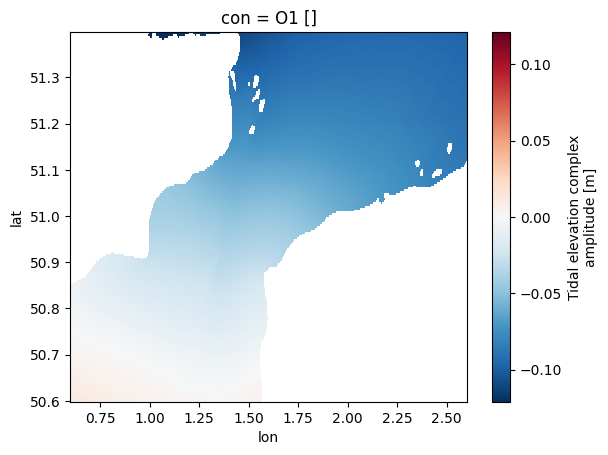

In [5]:
query.isel(con=5).h.real.plot() 

Plot of the tidal elevation at the last time step of the query

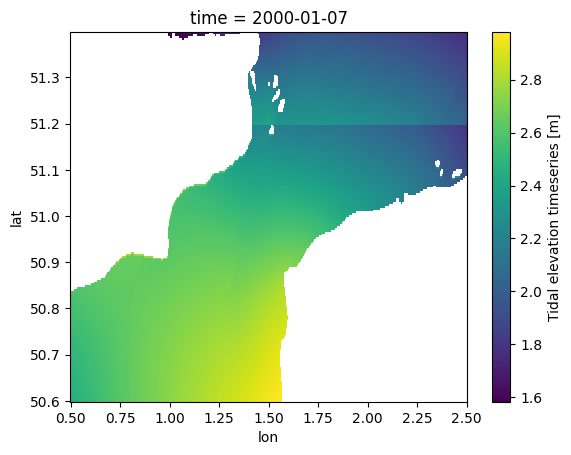

In [12]:
query.isel(time=-1).h_ts.real.plot() 

Just to check, the small discontinuity visible in the tidal elevation timeseries is also found in the real part of the M2 constituent. This is not an artefact due to interpolation but more likely something due to the transition between two high resolution grids.

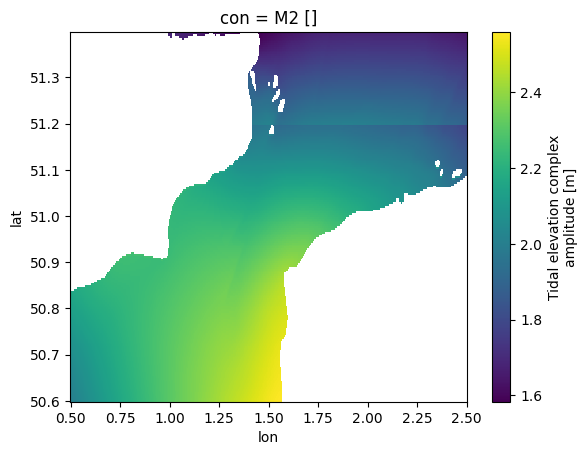

In [8]:
query.isel(con=0).h.real.plot()

Now selecting a random point in the data retrieved for the query, we can plot the time series of the water level at that point.

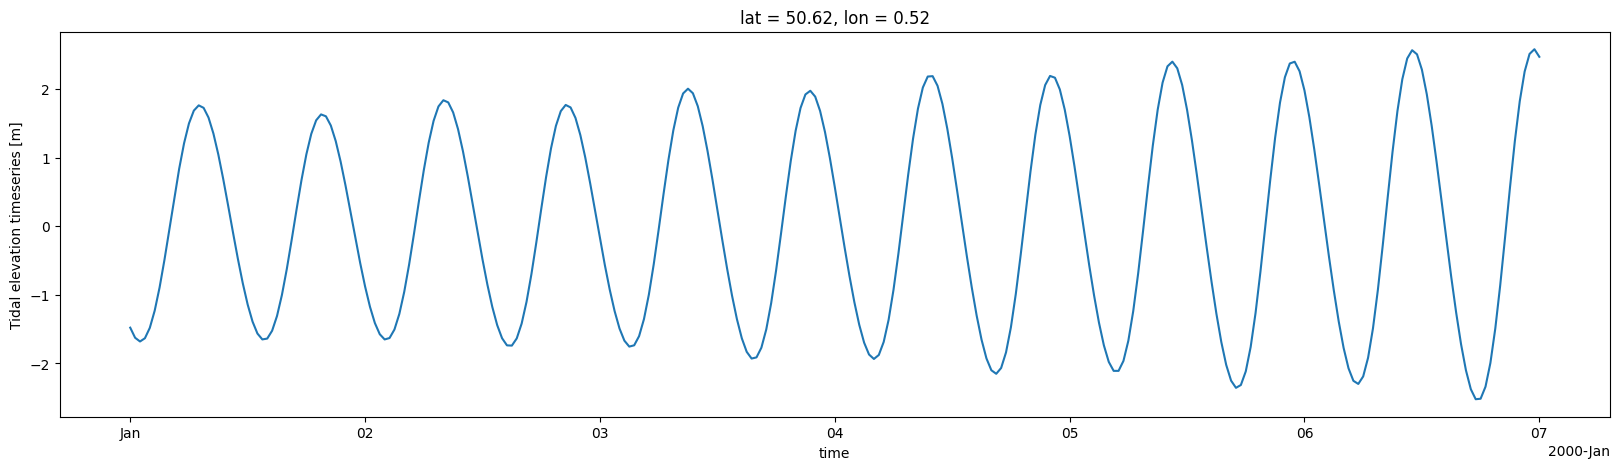

In [11]:
query.h_ts.isel(lon=5, lat=5).plot(figsize=(20,5))

# Example query 4

Tidal currents over a trajectory represented as a set of locations with a time of each location

In [51]:
# Trajectory

query = datamesh.query({"datasource": "oceanum_global_multiscale_tidegrid",
                        "timefilter": {"type": "trajectory",
                                       "times": ["2024-05-27T00:00:00",
                                                 "2024-05-27T01:00:00",
                                                 "2024-05-27T02:00:00",
                                                 "2024-05-27T03:00:00",
                                                 "2024-05-27T04:00:00",]},
                        "geofilter": {"type": "feature",
                                      "geom": {
                                          "type": "Feature",
                                          "geometry": {
                                              "type": "MultiPoint",
                                              "coordinates": [[0.5, 50.6],
                                                              [1., 50.8],
                                                              [1.5, 51.],
                                                              [2., 51.2],
                                                              [2.5, 51.4]]
                                          }
                                      }
                        },
                        "variables": ["u_ts", "v_ts"]
                })
query

<xarray.Dataset> Size: 88B
Dimensions:      (point: 5)
Coordinates:
    spatial_ref  int64 8B 0
Dimensions without coordinates: point
Data variables:
    u_ts         (point) float64 40B 0.7266 0.5492 0.7477 0.7276 0.4873
    v_ts         (point) float64 40B 0.3539 0.4865 1.057 0.615 0.5957
Attributes:
    description:     Oceantide tidal constituents
    version:         v0.2
    xinterp_method:  linear
    _coordinates:    {"t":"time","x":"lon","y":"lat"}
    _request_size:   88

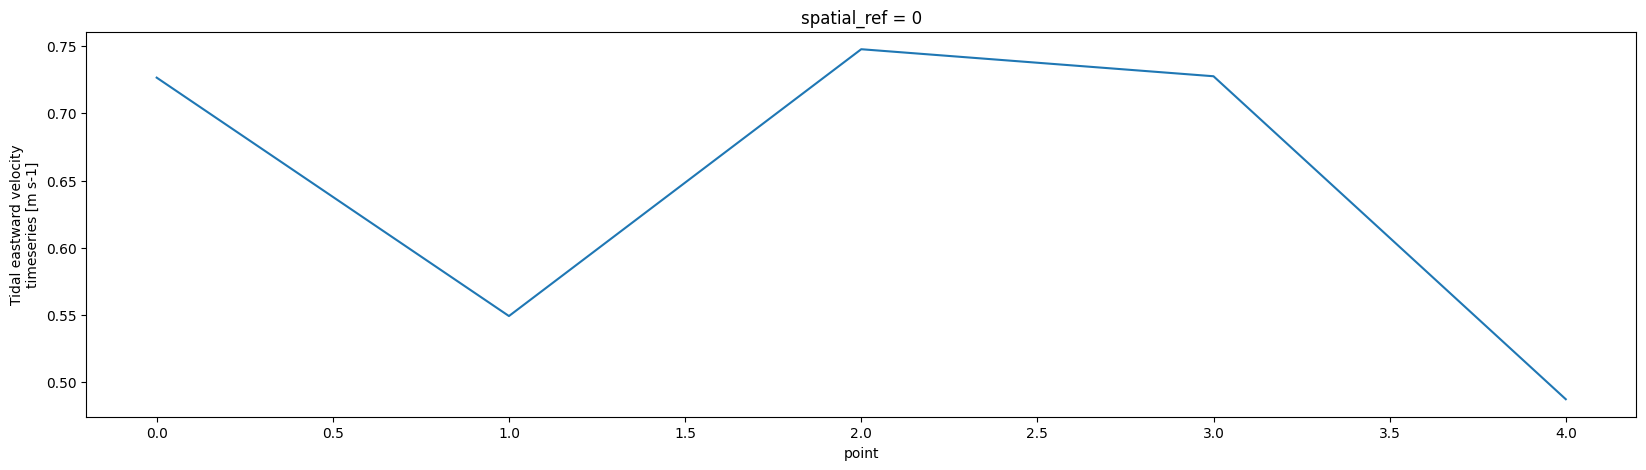

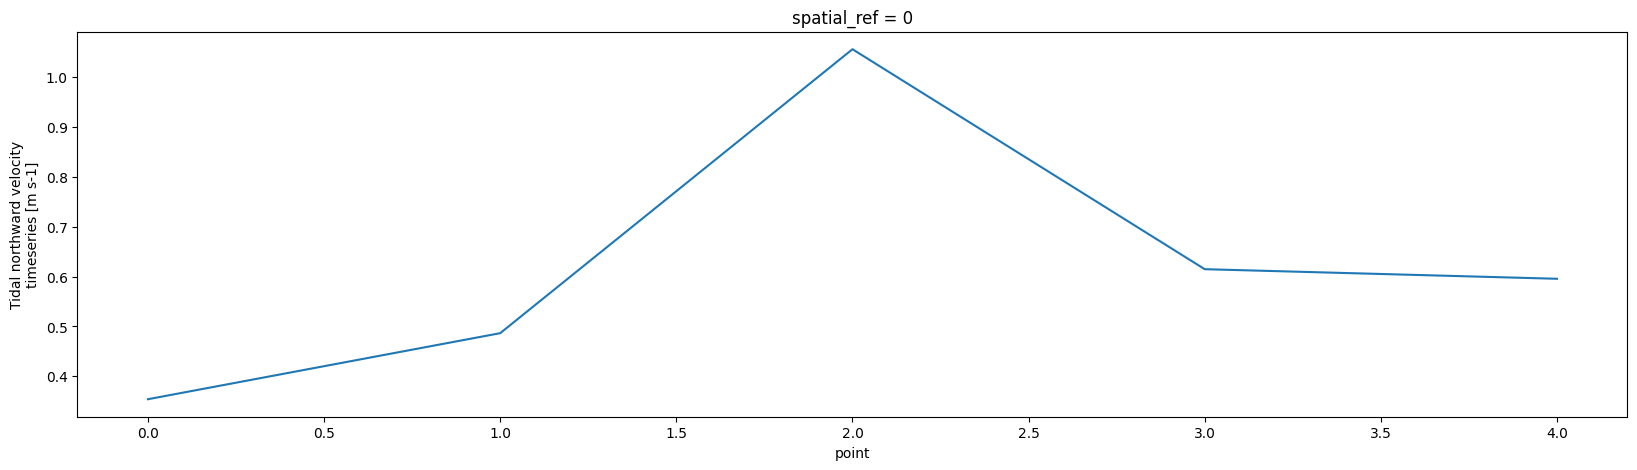

In [53]:
query.u_ts.plot(figsize=(20,5))
query.v_ts.plot(figsize=(20,5))

# Timeseries version only

A timeseries only version of the dataset for which the constituents are hidden is also available in datamesh.

In [13]:
new = datamesh.load_datasource("oceanum_global_multiscale_tidegrid_timeseries")
new

<xarray.Dataset> Size: 24PB
Dimensions:   (lat: 45001, lon: 90000, time: 485640)
Coordinates:
  * lat       (lat) float64 360kB -90.0 -90.0 -89.99 -89.99 ... 89.99 90.0 90.0
  * lon       (lon) float64 720kB 0.0 0.004 0.008 0.012 ... 360.0 360.0 360.0
  * time      (time) datetime64[ns] 4MB 1970-01-01 ... 2025-05-26T23:00:00
Data variables:
    dep       (lat, lon) float32 16GB dask.array<chunksize=(128, 128), meta=np.ndarray>
    h_ts      (time, lat, lon) float32 8PB dask.array<chunksize=(1024, 128, 128), meta=np.ndarray>
    landmask  (lat, lon) float16 8GB dask.array<chunksize=(128, 128), meta=np.ndarray>
    u_ts      (time, lat, lon) float32 8PB dask.array<chunksize=(1024, 128, 128), meta=np.ndarray>
    v_ts      (time, lat, lon) float32 8PB dask.array<chunksize=(1024, 128, 128), meta=np.ndarray>